In [136]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [137]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import h5py
import tensorflowjs as tfjs

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [138]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('classsss.csv', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

C:\Users\hu021\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,30,waving,4.582675e+09,-0.353728,5.283476,7.901423
1,30,waving,4.588676e+09,-0.277715,5.296046,8.208766
2,30,waving,4.594678e+09,-0.277715,5.296046,8.208766
3,30,waving,4.607681e+09,-0.238512,5.258937,8.365580
4,30,waving,4.614681e+09,-0.201104,5.226916,8.395206


In [140]:
df.shape

(131205, 6)

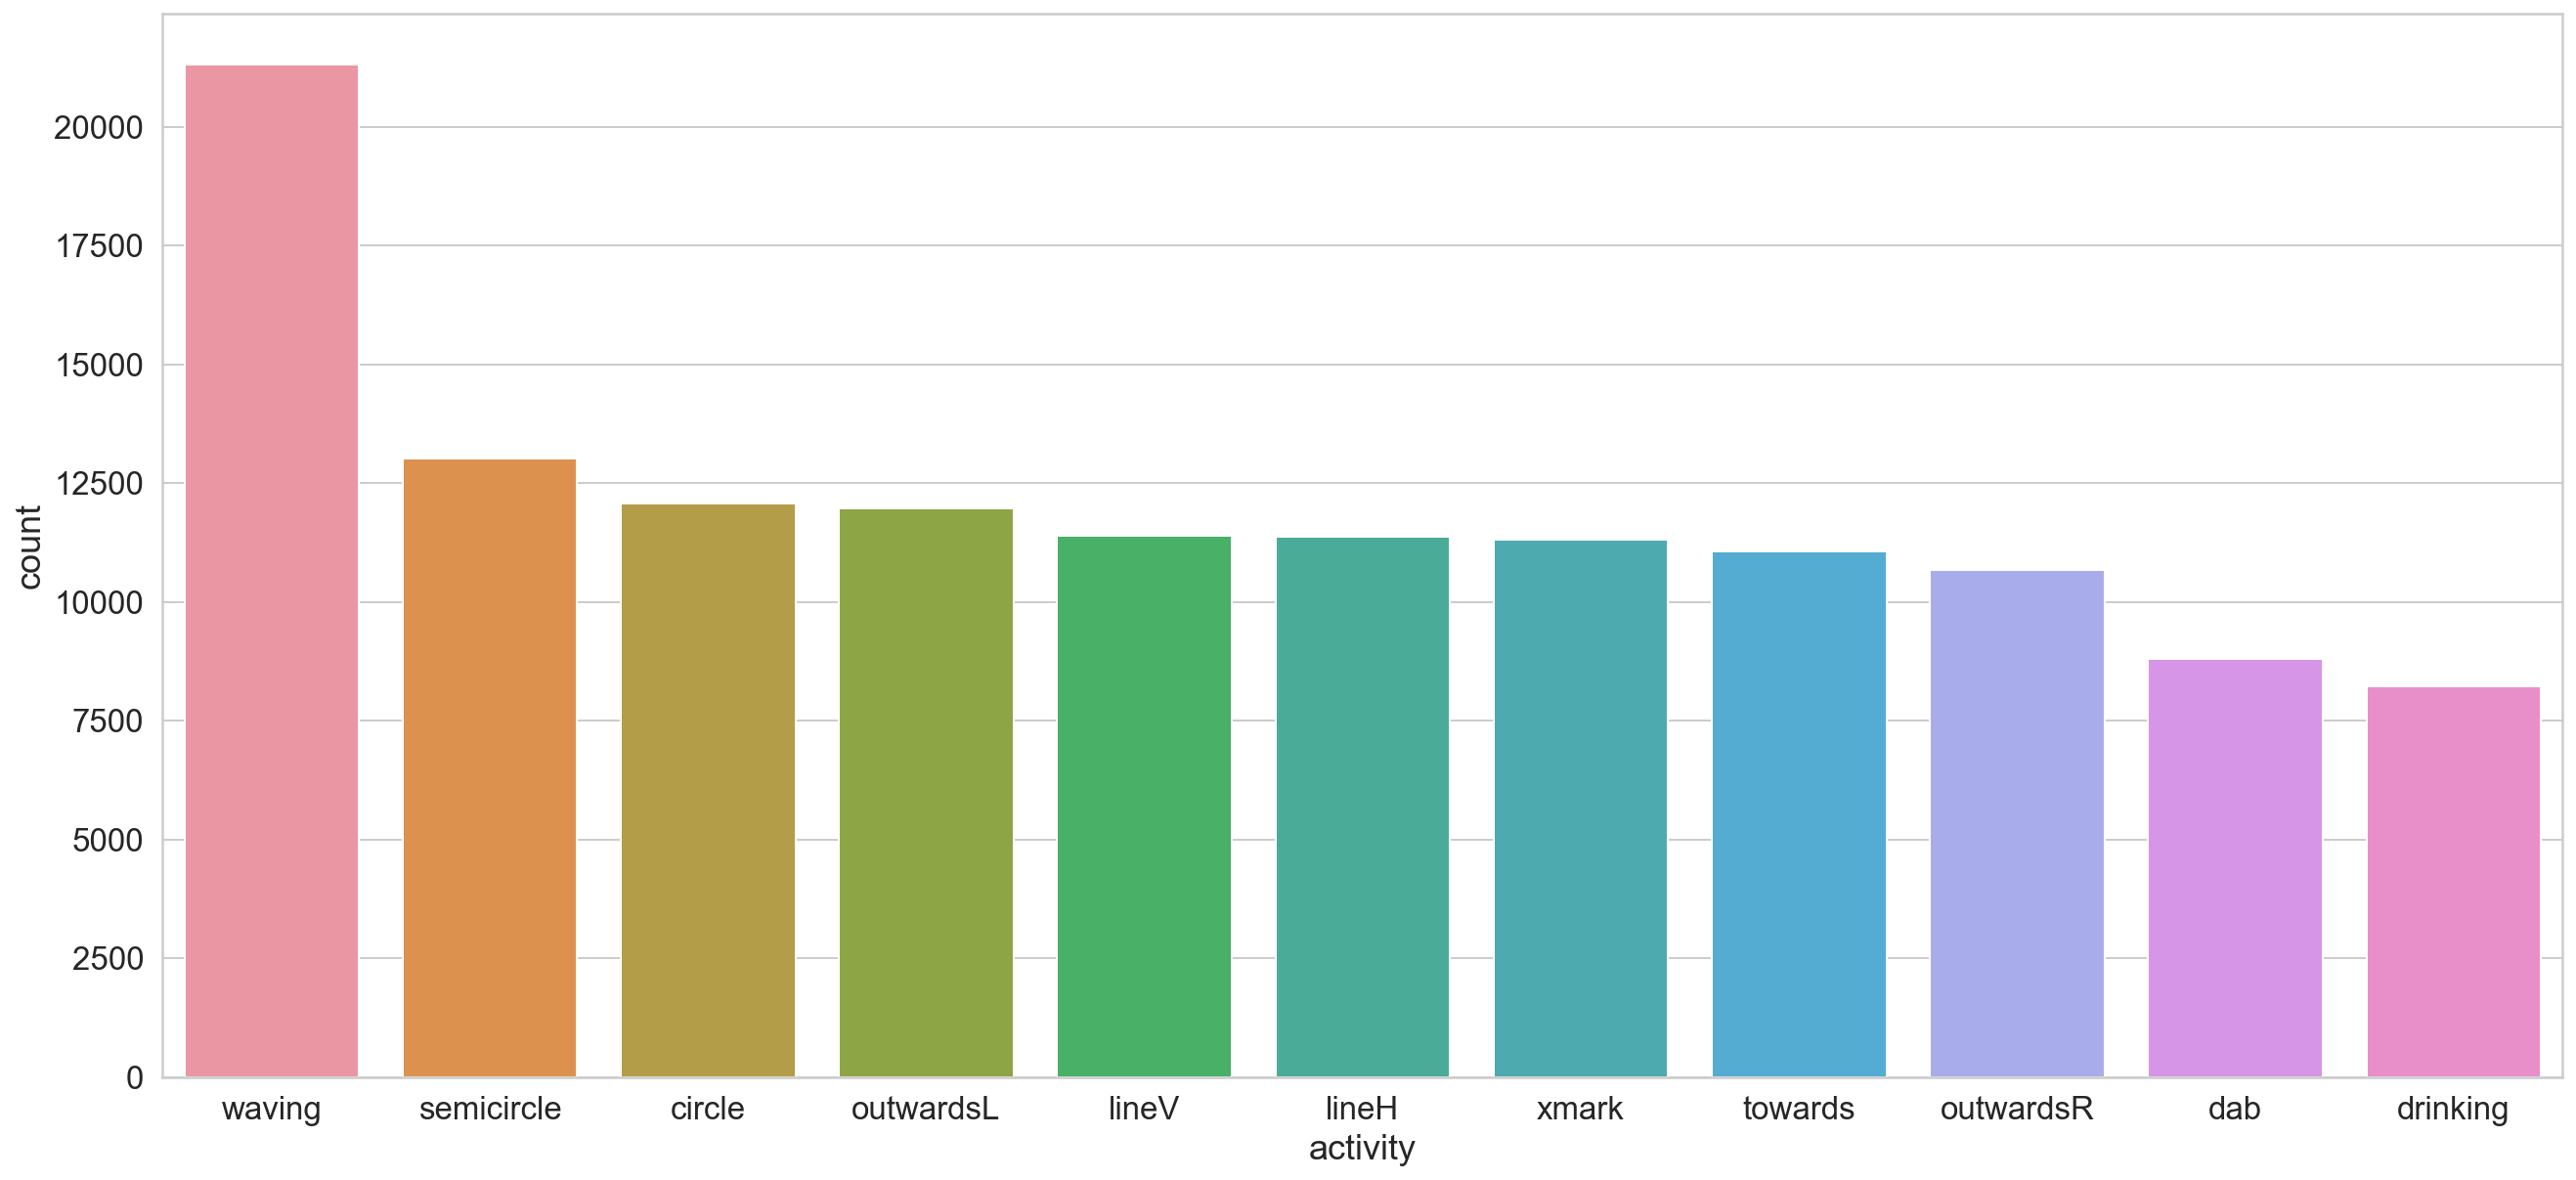

In [141]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

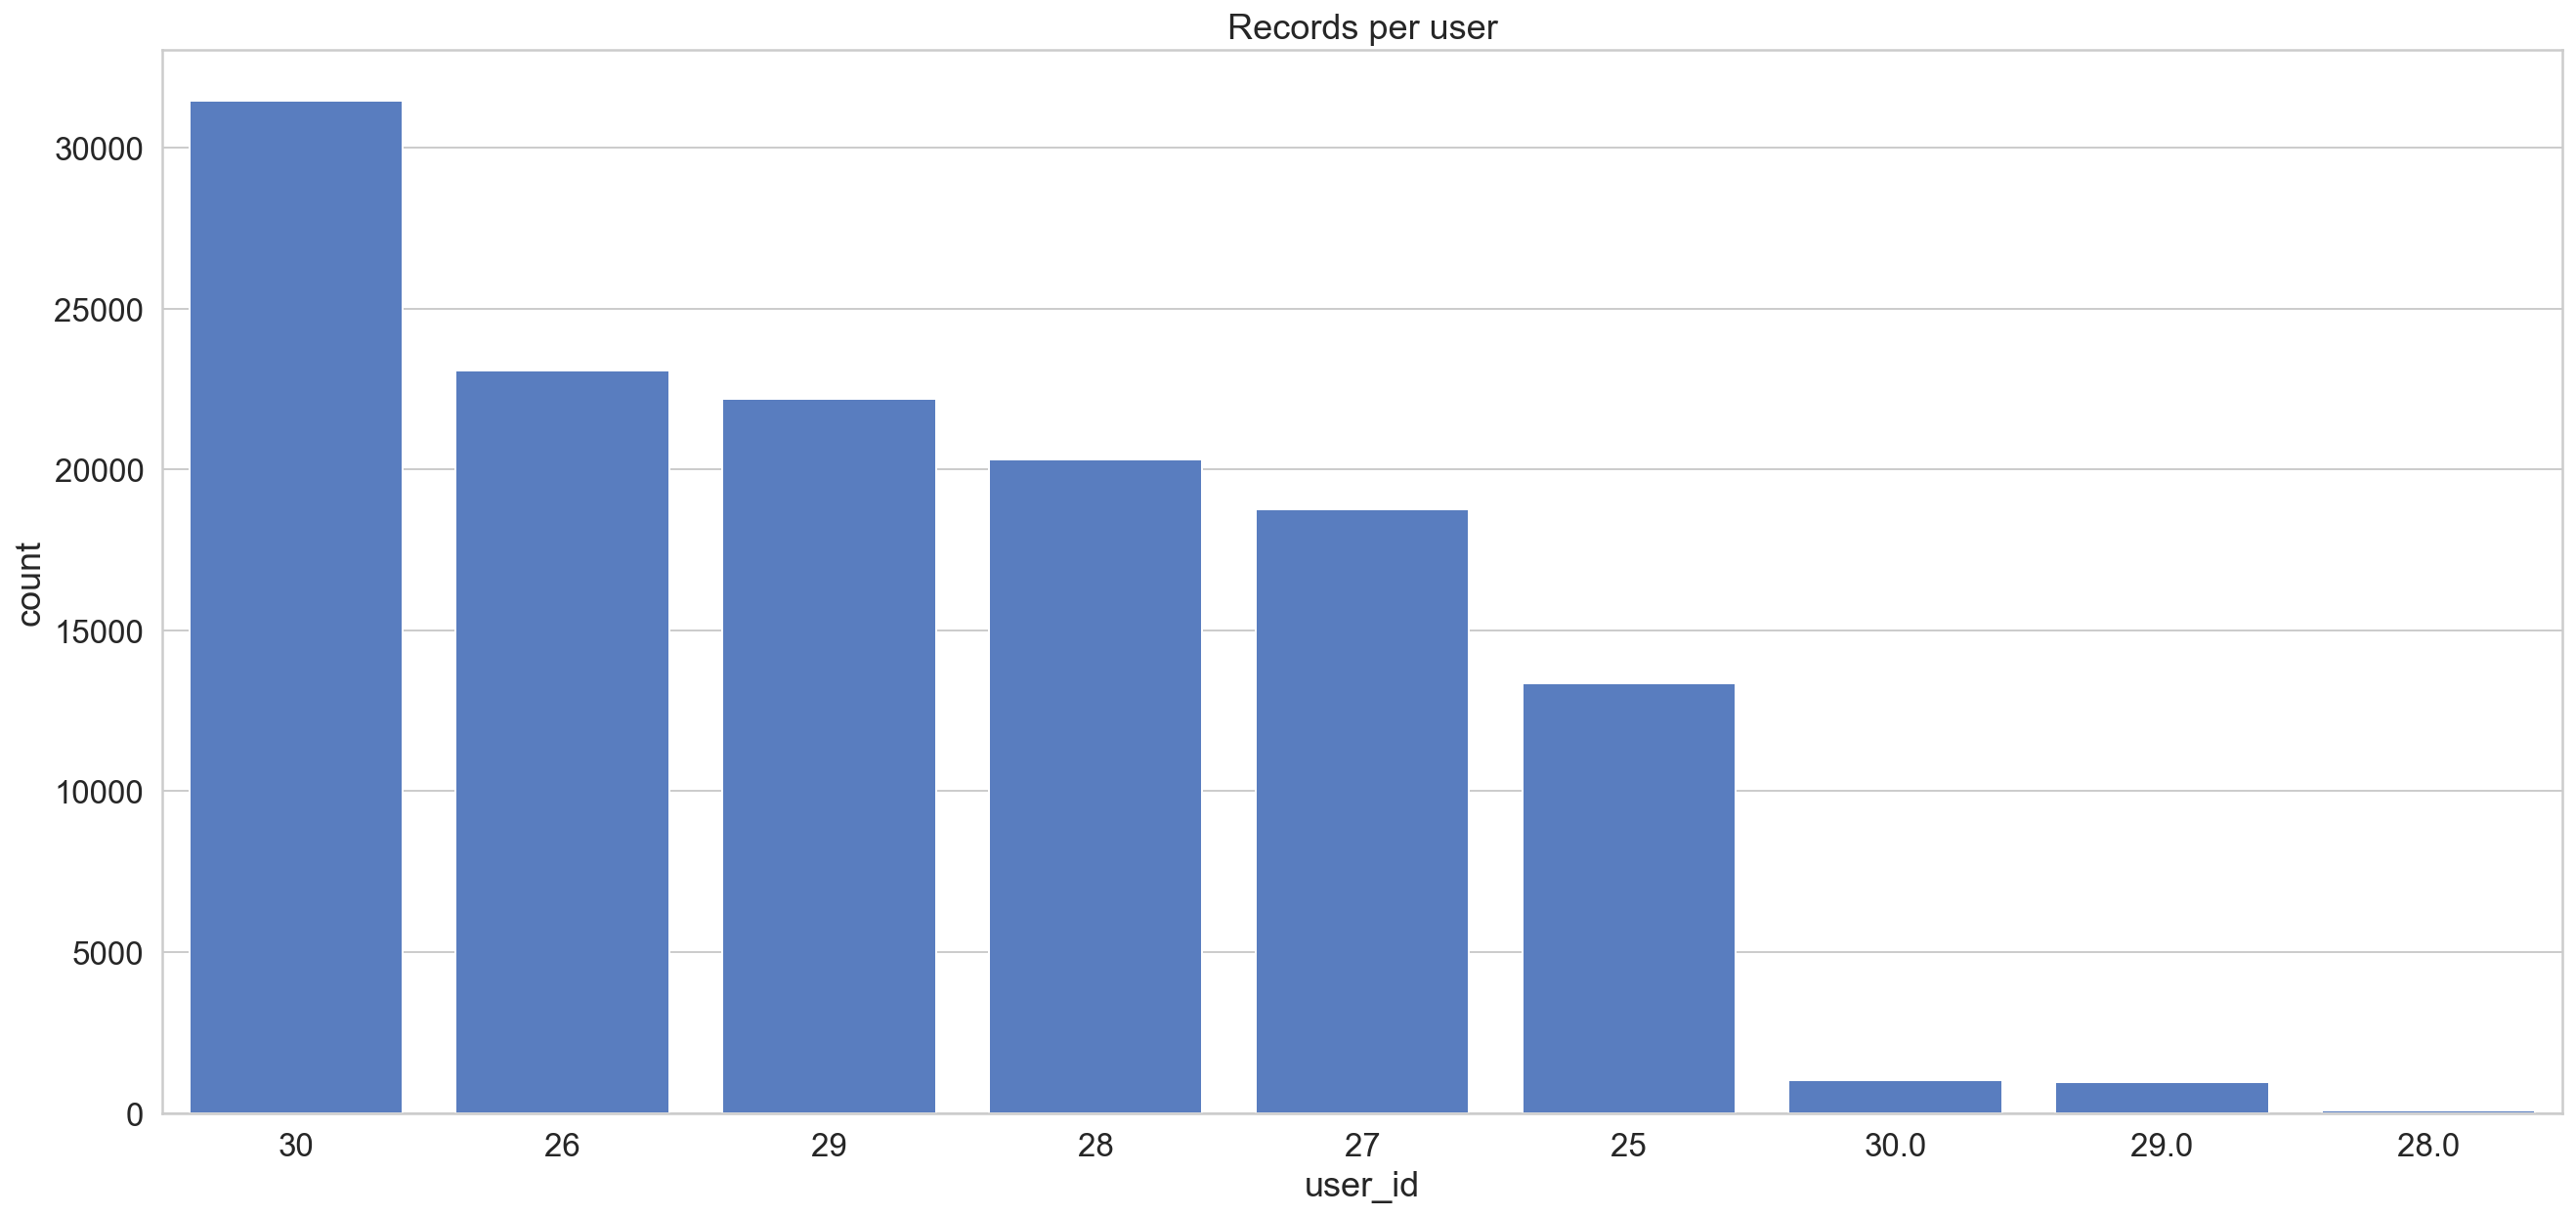

In [142]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [143]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

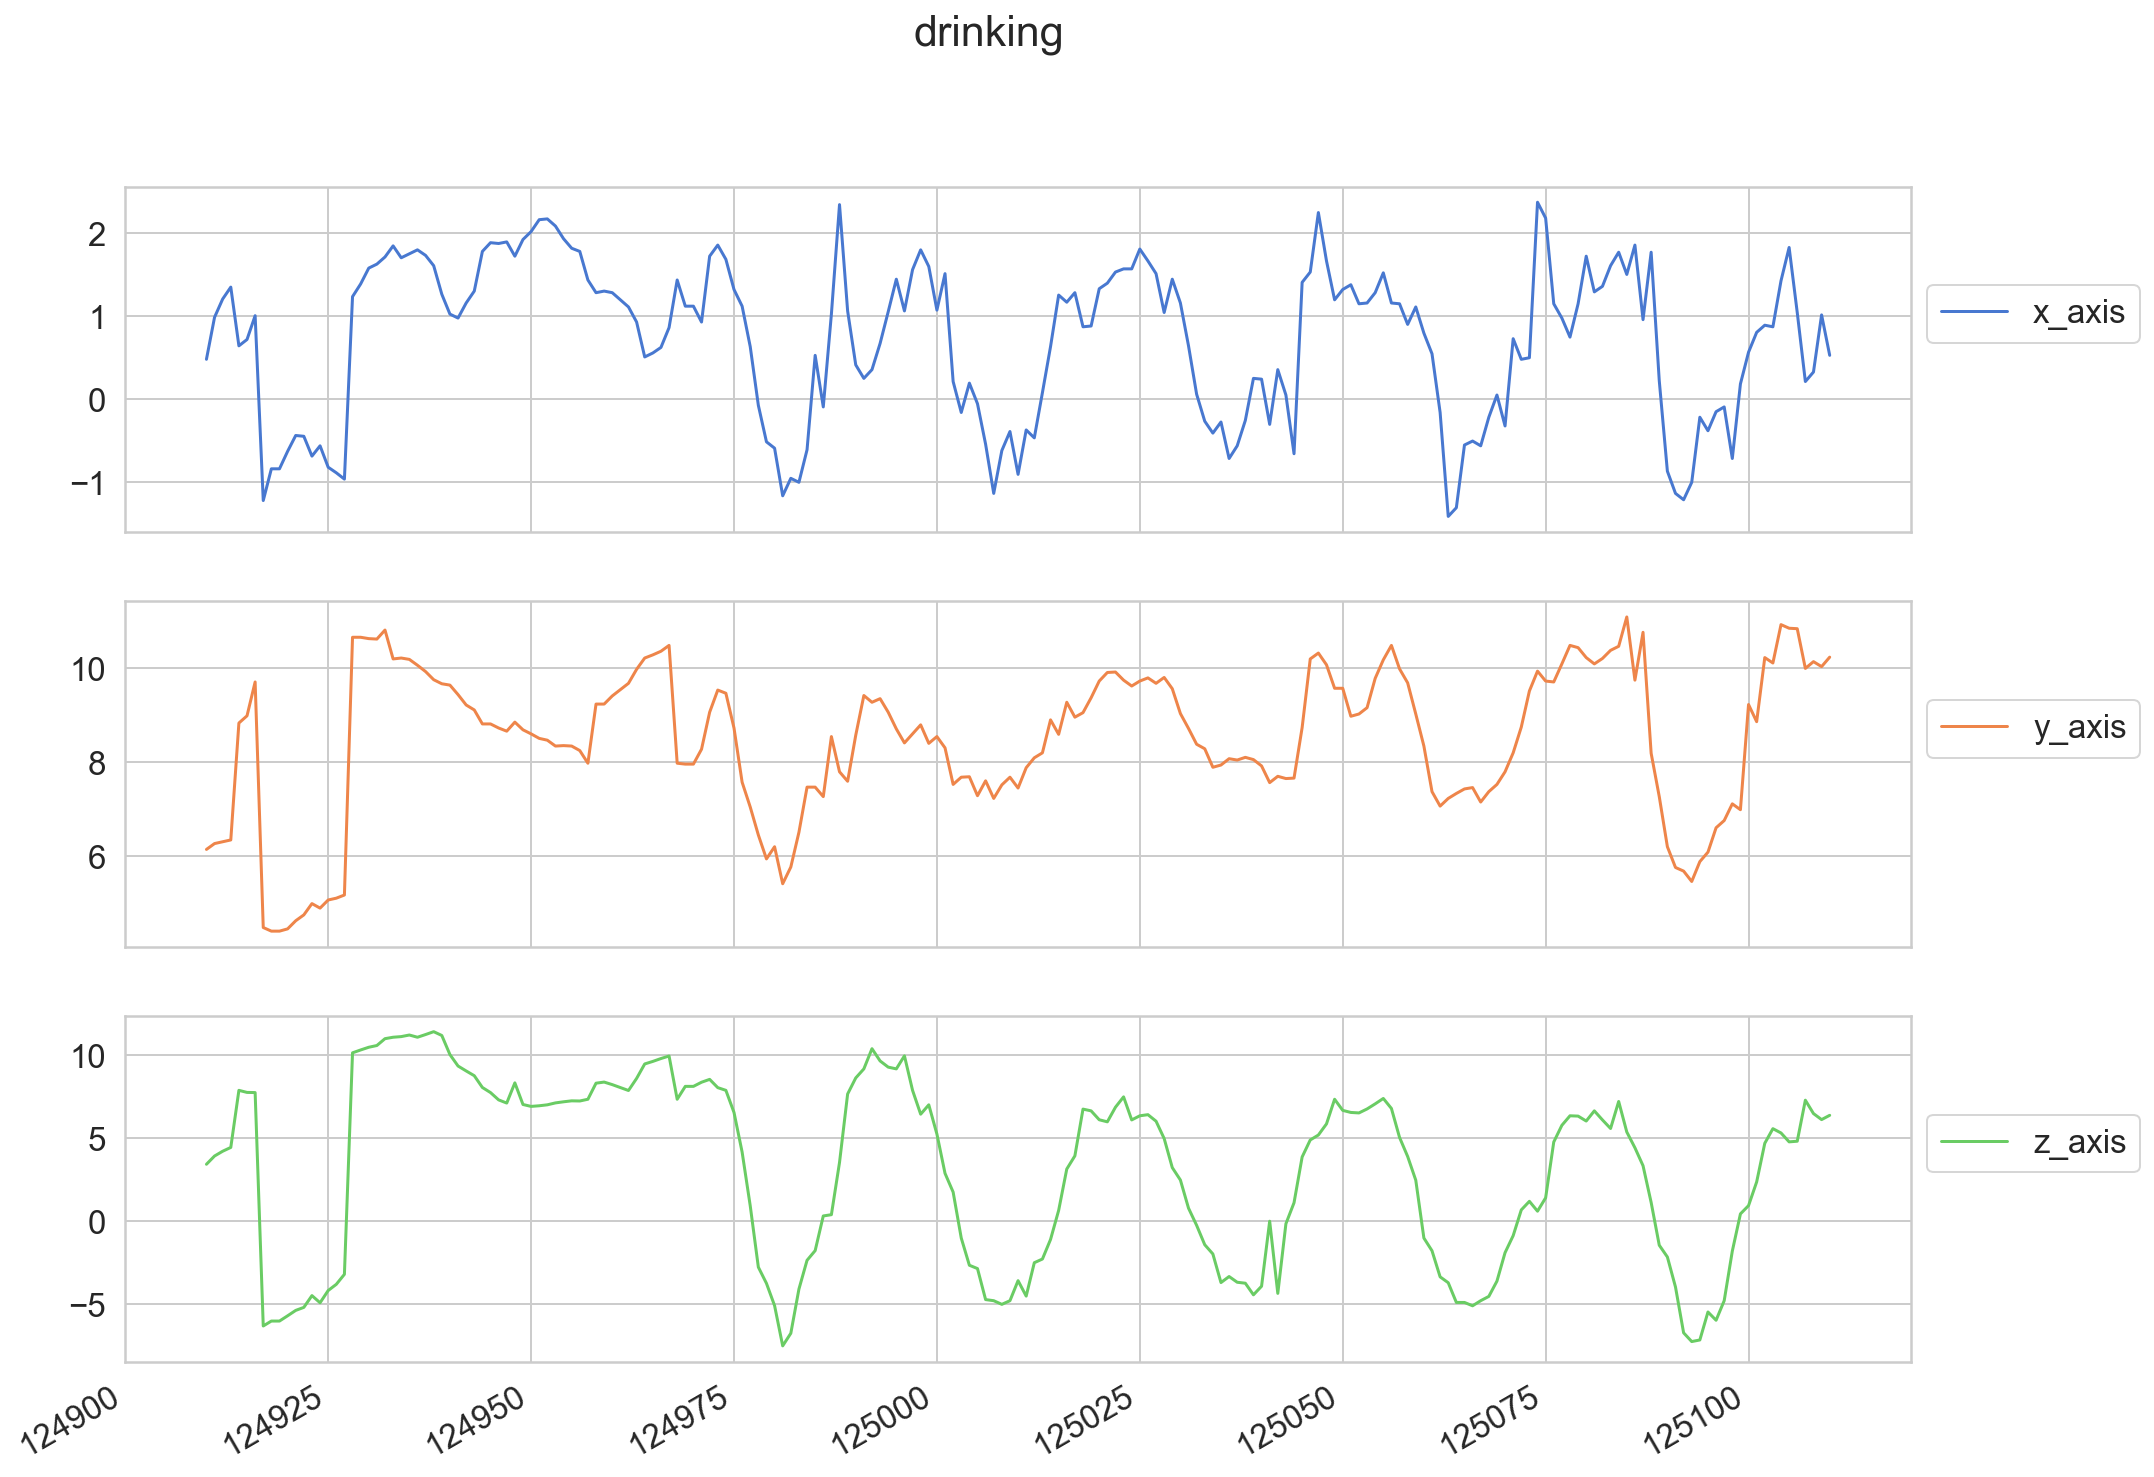

In [144]:
plot_activity("drinking", df);

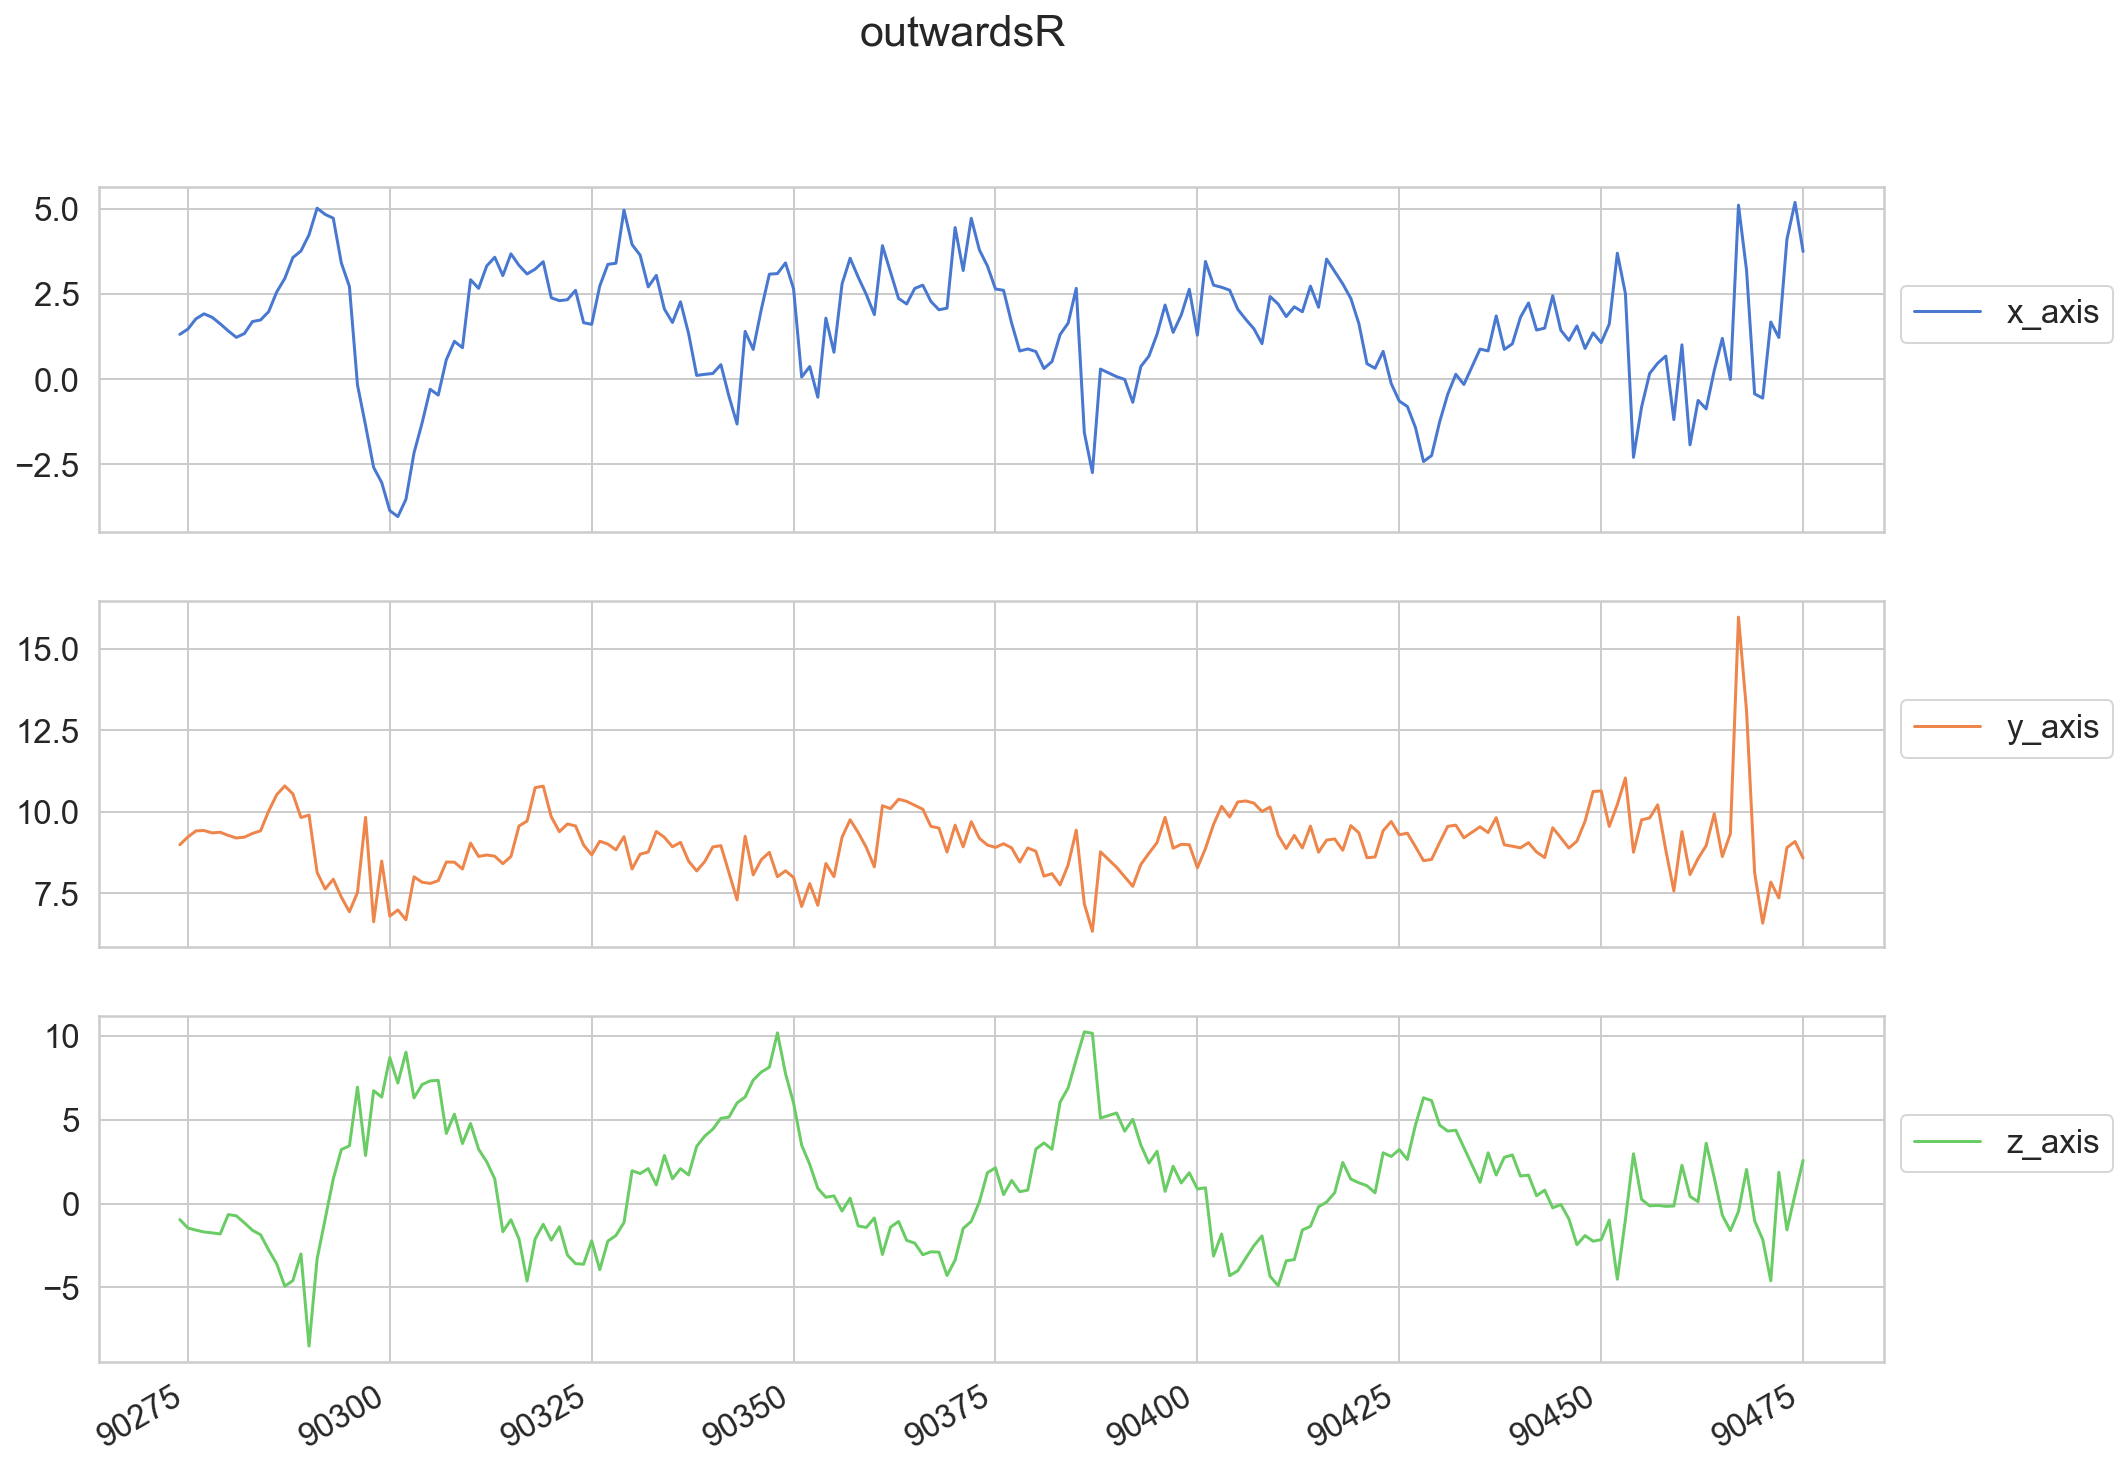

In [145]:
plot_activity("outwardsR", df);

In [146]:
df['user_id'] = df['user_id'].astype(int)
df_train = df[df['user_id'] < 30]
df_test = df[df['user_id'] >= 30]

In [147]:
"""from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1,shuffle=False)
print(df_train.shape)
df_train.head()"""

'from sklearn.model_selection import train_test_split\n\ndf_train, df_test = train_test_split(df, test_size=0.1,shuffle=False)\nprint(df_train.shape)\ndf_train.head()'

In [148]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

C:\Users\hu021\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\hu021\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [149]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [150]:
print(X_train.shape, y_train.shape)

(2464, 200, 3) (2464, 1)


In [151]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [152]:
print(X_test.shape, y_test.shape)

(807, 200, 3) (807, 11)


In [153]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [154]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

35/35 [==============================] - 22s 639ms/step - loss: 1.8385 - acc: 0.3505 - val_loss: 4.2279 - val_acc: 0.0000e+00
Epoch 2/20
35/35 [==============================] - 22s 622ms/step - loss: 1.1581 - acc: 0.5377 - val_loss: 5.5636 - val_acc: 0.0000e+00
Epoch 3/20
35/35 [==============================] - 22s 630ms/step - loss: 1.0156 - acc: 0.6094 - val_loss: 5.3082 - val_acc: 0.2308
Epoch 4/20
35/35 [==============================] - 21s 613ms/step - loss: 0.7779 - acc: 0.6942 - val

In [155]:
"""def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
        """
        :param session: session of tensorflow that needs to be converted
                 :param keep_var_names: variables that need to be retained, default all convert constant
                 :param output_names: the name of the output
                 :param clear_devices: Whether to remove device directives for better portability
        :return:
        """
        from tensorflow.python.framework.graph_util import convert_variables_to_constants
        graph = session.graph
        with graph.as_default():
            freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
            output_names = output_names or []
                         # If the output name is specified, copy a new Tensor and name it with the specified name
            if len(output_names) > 0:
                for i in range(output_names):
                                         # Copy a new Tensor in the current graph, specify the name
                  tf.identity(model.model.outputs[i], name=output_names[i])
            output_names += [v.op.name for v in tf.global_variables()]
            input_graph_def = graph.as_graph_def()
            if clear_devices:
                for node in input_graph_def.node:
                    node.device = ""
            frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                          output_names, freeze_var_names)
            return frozen_graph"""

IndentationError: unexpected indent (<ipython-input-155-b5770c14d2e7>, line 3)

In [ ]:
"""from keras import backend as K
import tensorflow as tf
from keras.models import load_model
import h5py

model.load_model("model.h5")
print(model.input.op.name)
print(model.output.op.name)
 # output_names
frozen_graph = freeze_session(K.get_session(), output_names=["output"])
tf.train.write_graph(frozen_graph, "./", "model.pb", as_text=False)"""


# New Section

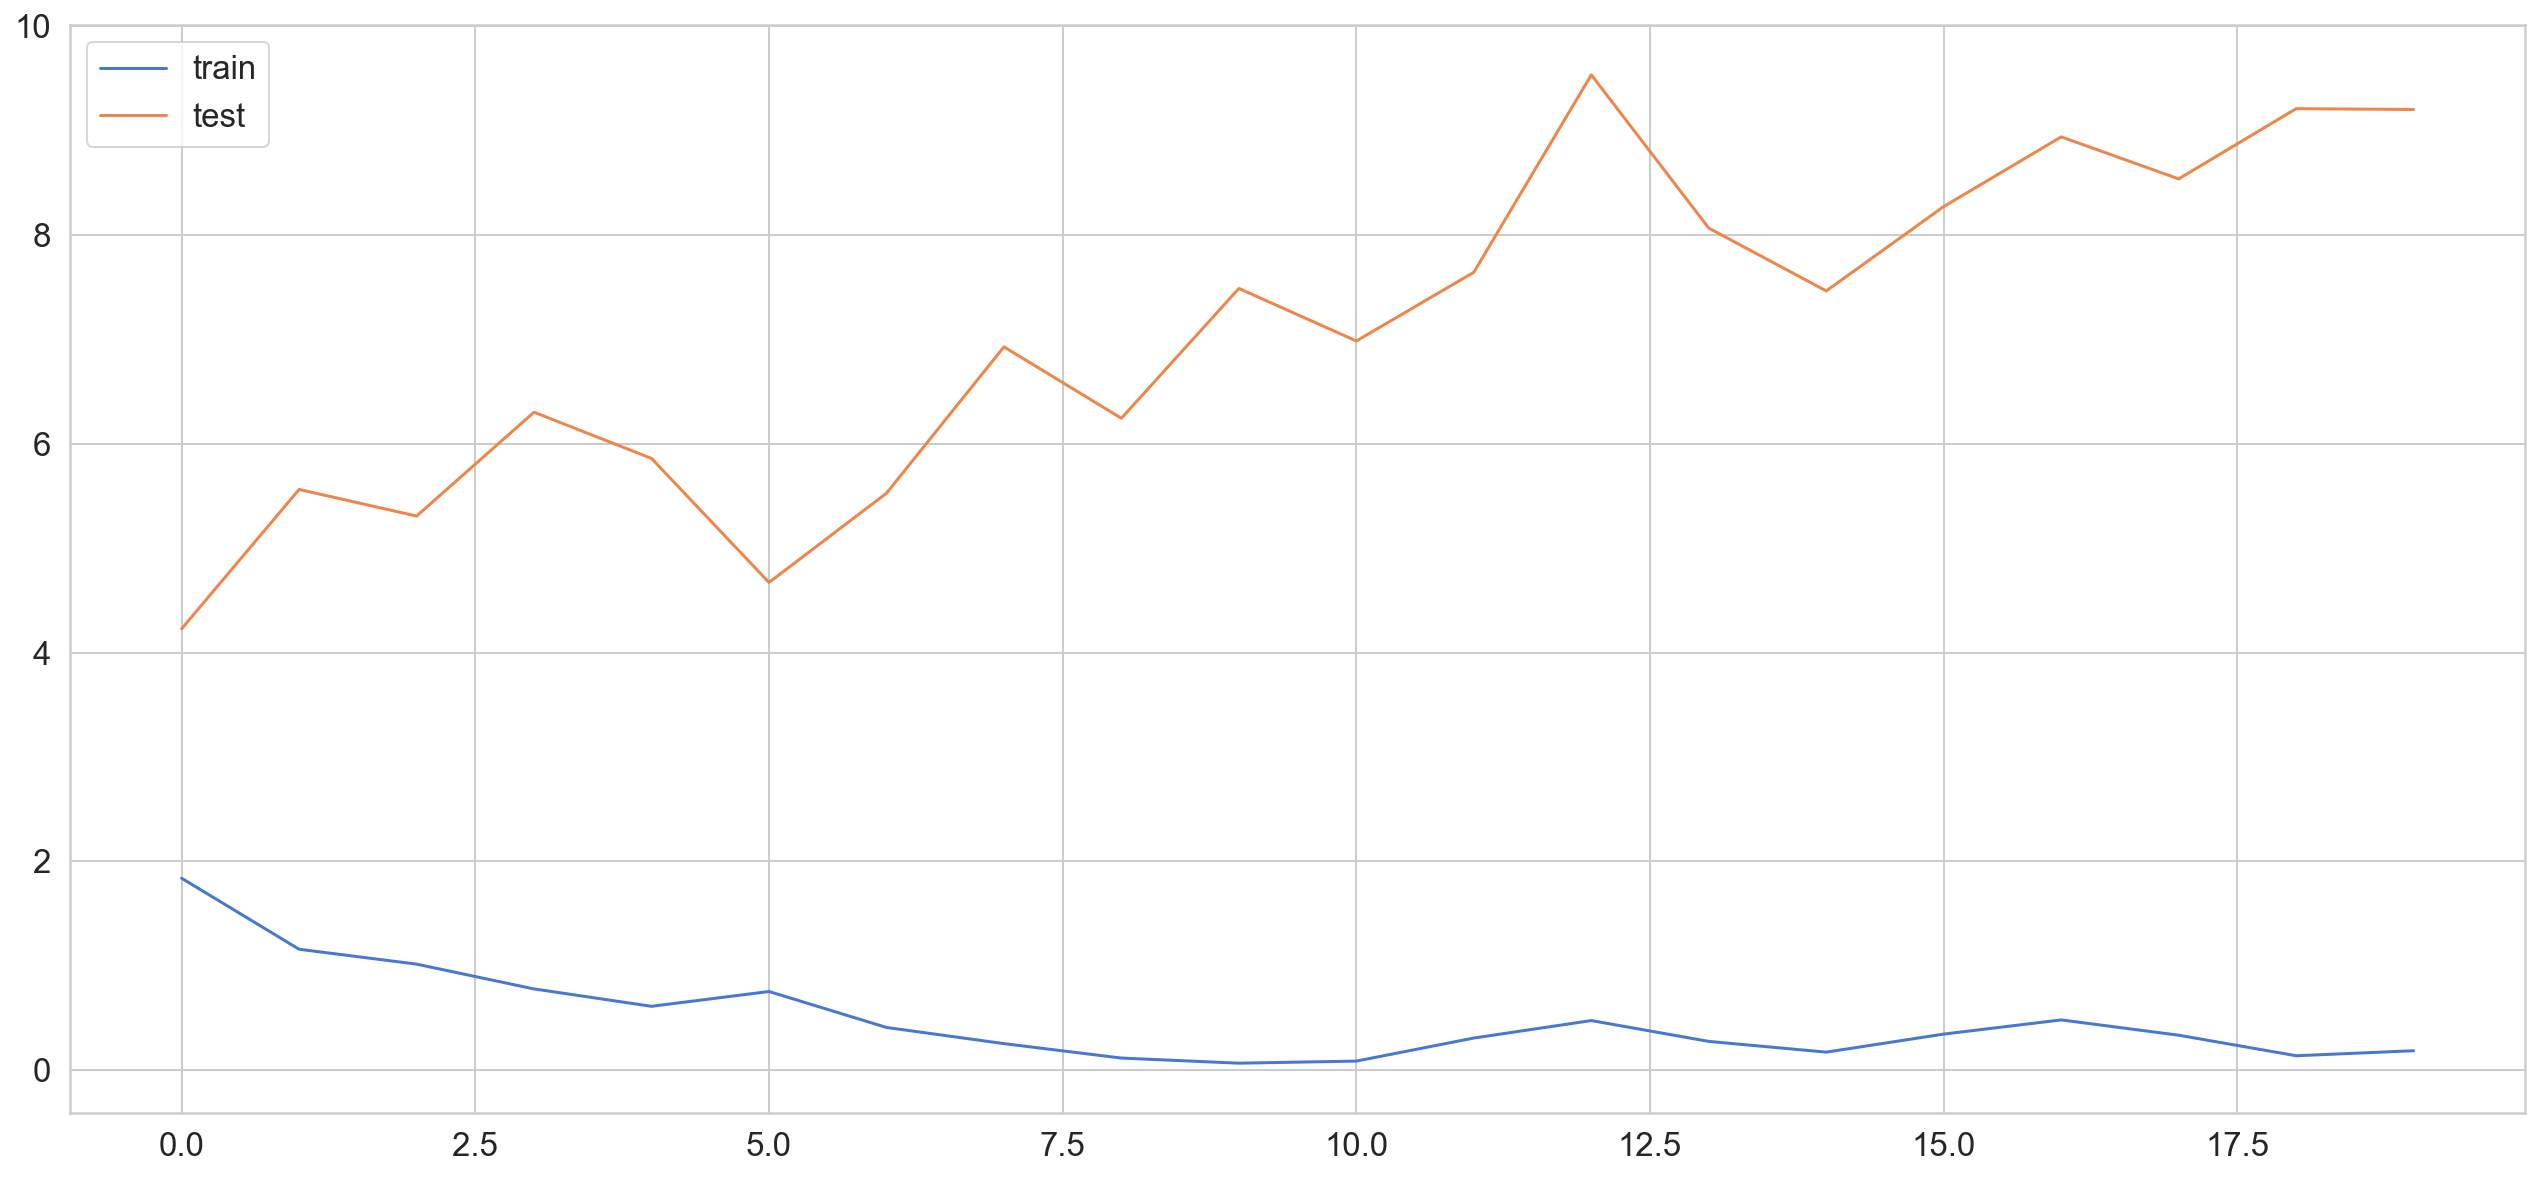

In [156]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [157]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 2s 69ms/step - loss: 1.2508 - acc: 0.7770


[1.2508306503295898, 0.7769516706466675]

In [158]:
y_pred = model.predict(X_test)

In [159]:
print(y_pred)

[[1.8772049e-06 4.2548680e-05 1.0799092e-06 ... 8.7386184e-07
  9.9966300e-01 8.6281994e-05]
 [5.2442010e-07 1.1125842e-06 1.3571653e-07 ... 6.7373423e-07
  9.9838865e-01 1.4817716e-05]
 [2.0805637e-06 7.6078206e-05 3.0811276e-07 ... 1.5272846e-07
  9.9990439e-01 8.7346507e-06]
 ...
 [3.1390471e-05 1.2502233e-05 4.6419345e-08 ... 7.0217361e-08
  4.2842679e-05 9.7470587e-01]
 [4.2886470e-04 4.4261512e-01 7.9291942e-07 ... 6.5786000e-05
  1.1078033e-02 2.2459994e-01]
 [1.5246728e-04 1.4101034e-03 9.2411636e-07 ... 3.5783764e-06
  3.8576909e-04 7.3162776e-01]]


In [160]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(21, 19)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(230, 30, n=9),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names, rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

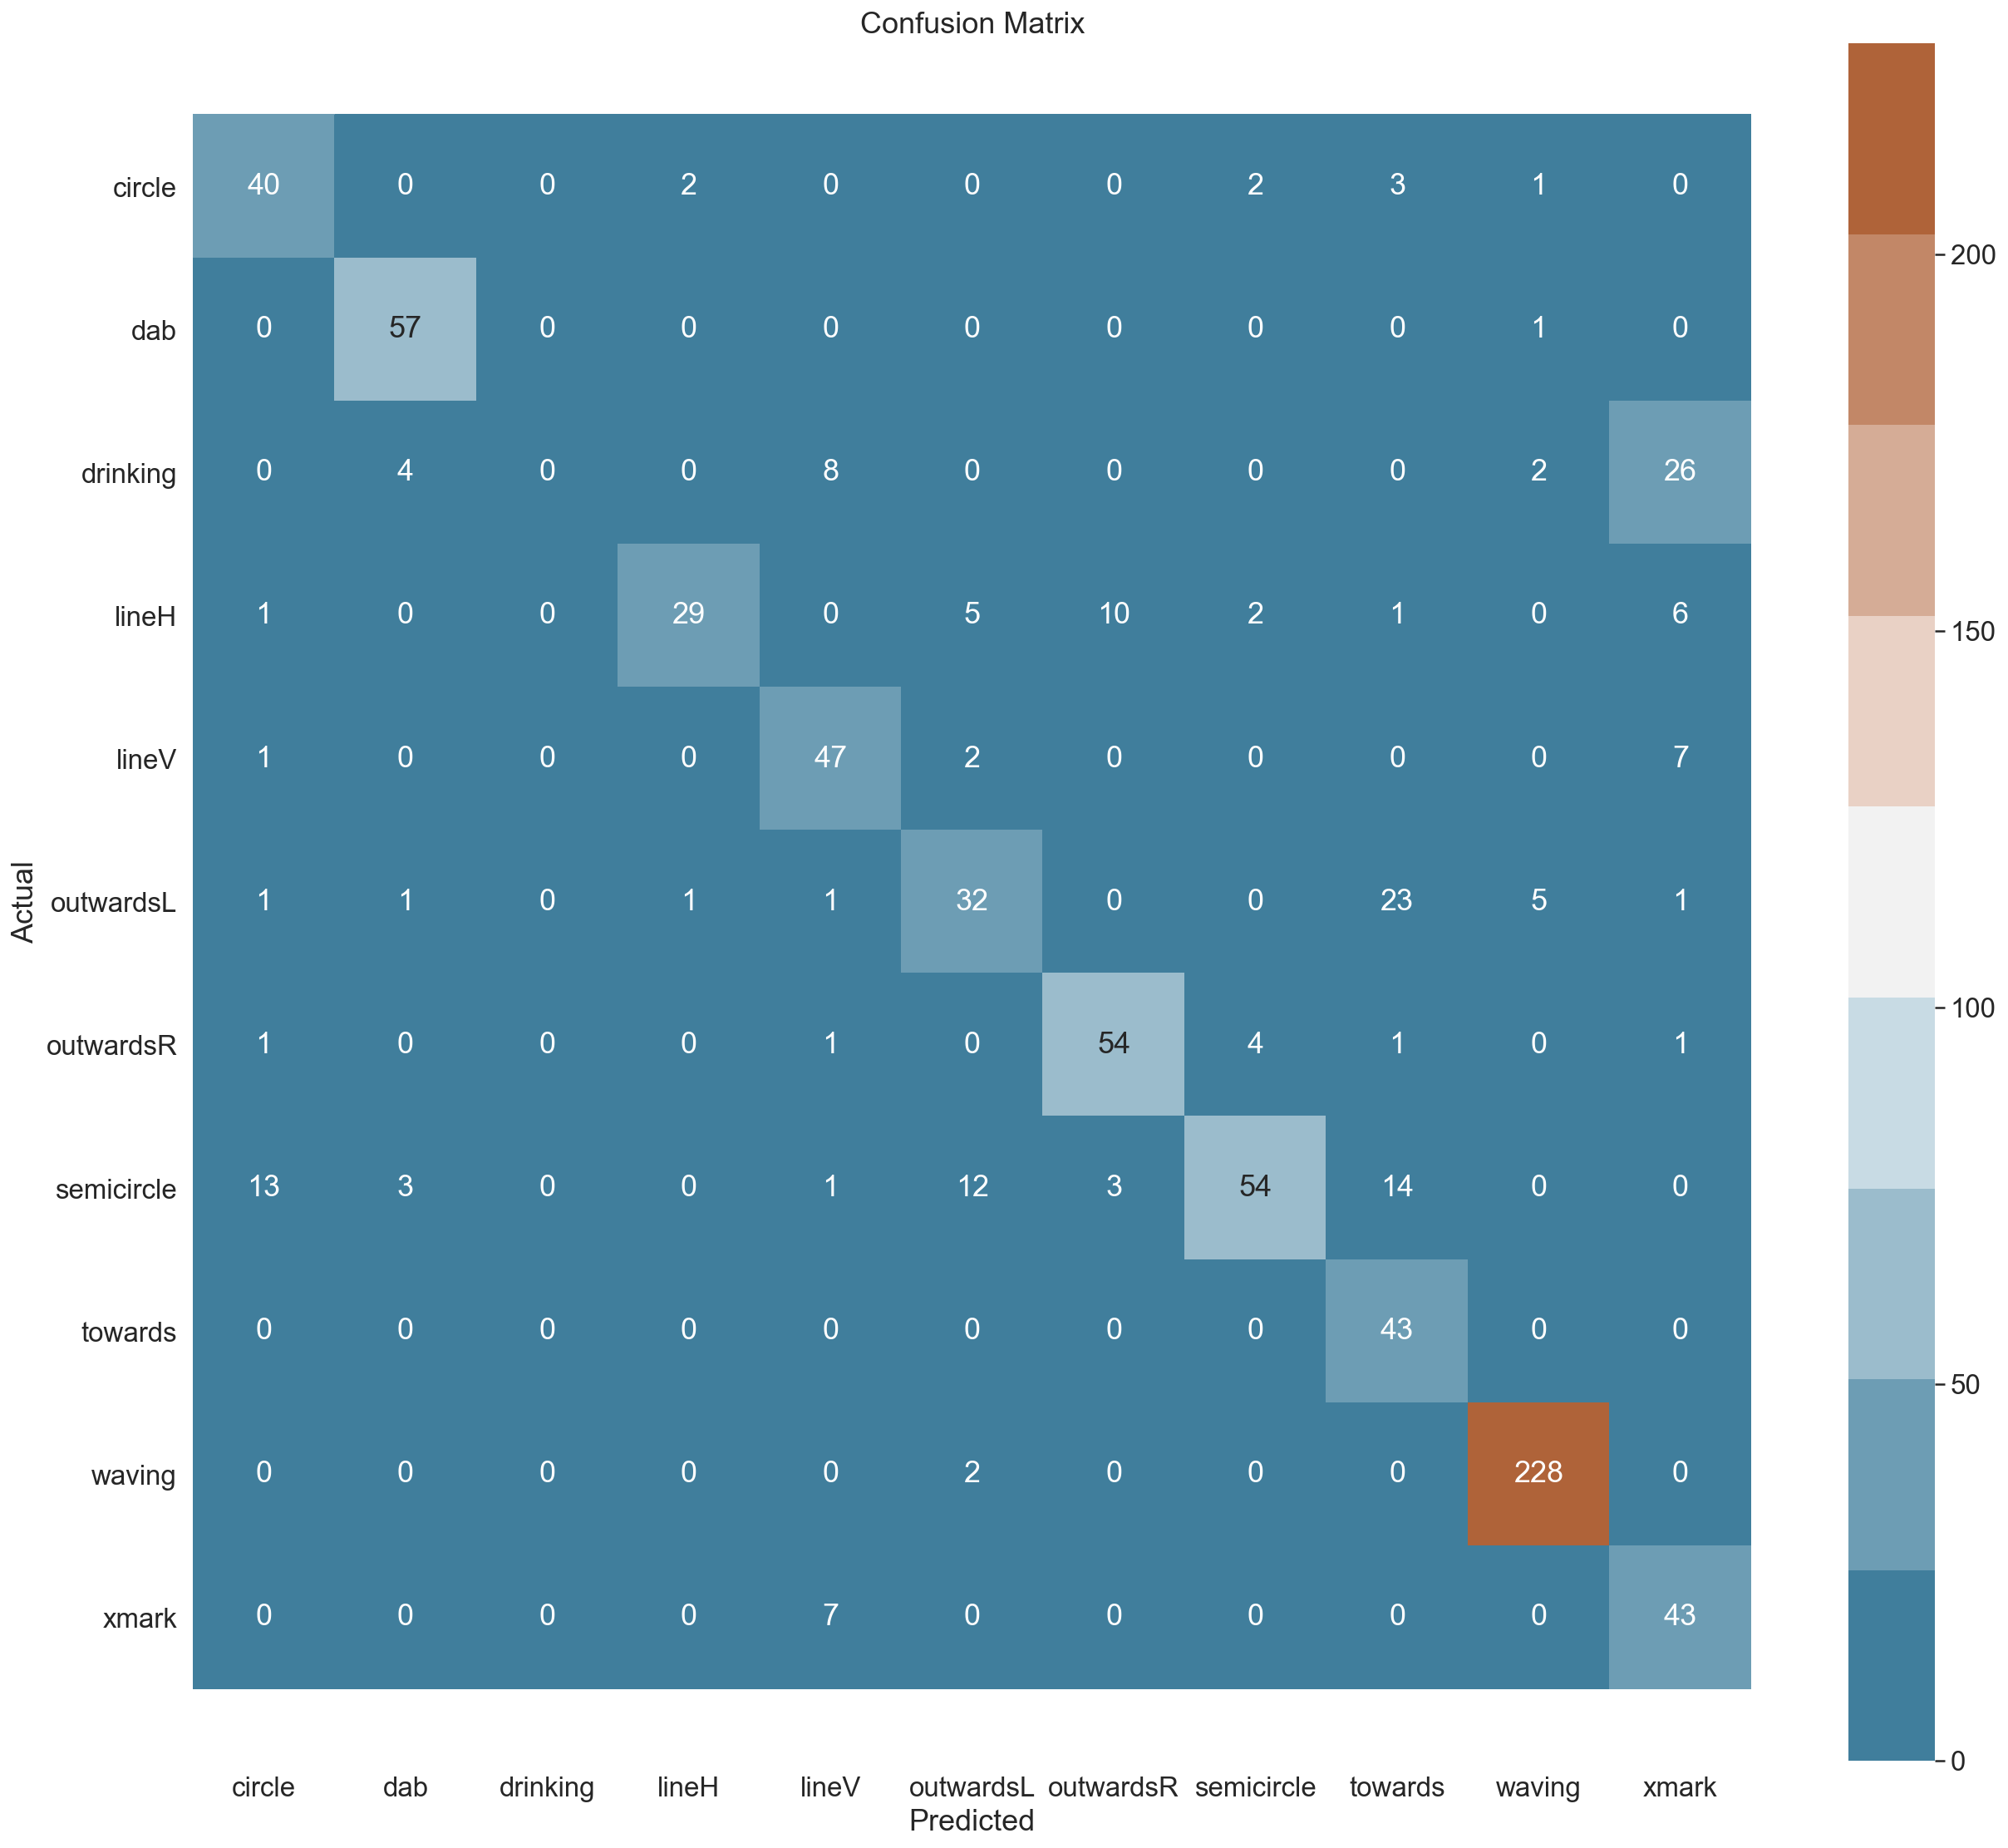

In [161]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [162]:
# Save the model
model.save_weights("iris_model_save")
model_as_json = model.to_json()

with open("iris_model_json", "w") as f:
	f.write(model_as_json)
